In [1]:
## Standard Library
import os
import json

## External Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as functional
# from torchsummary import summary
# import torchio as tio
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from skimage import io
# import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch.nn.functional as F
import nibabel as nib
# from HD_BET.utils import subdirs, subfiles
from dipy.viz import regtools


/home/amiro/nb15/anaconda3/envs/nb15/lib/python3.10/site-packages/dipy/viz/__init__.py:20: UserWarning: You do not have FURY installed. Therefore, 3D visualization functions will not work for you. Please install or upgrade FURY using pip install -U furyFor detailed installation instructions visit: https://fury.gl/
  warnings.warn(


CREATE DIRECTORIES

In [2]:
# General Data Directory ##TODO: Please fill in the appropriate directory
data_dir = '../Results'
# data_dir = os.path.join(dir, "DATA")
# mask_dir = os.path.join(dir, "MASK")
# label_dir = dir

CONVOLUTIONAL LAYER CALCULATIONS

In [3]:
# temp = sitk.Image()

# for f in os.listdir(data_dir):
#     img = sitk.ReadImage(os.path.join(data_dir, f))
#     sz = img.GetSize()
#     pad = [865-sz[0], 682-sz[1], 354-sz[2]]
#     img = 
#     print(img.GetSize())
    # img = torch.tensor(sitk.GetArrayFromImage(img))
    # pad = (0, 864-img.size()[2], 0, 682-img.size()[1], 0, 354-img.size()[0])
    # img = nn.functional.pad(img[None, :], pad, value=0)
    
# for g in os.listdir(mask_dir):
#     mask = sitk.ReadImage(f)
#     mask = torch.tensor(sitk.GetArrayFromImage(mask))
#     pad = (0, 864-mask.size()[2], 0, 682-mask.size()[1], 0, 354-mask.size()[0])
#     mask = nn.functional.pad(mask[None, :], pad, value=0)
# layer 1, torch.Size([1, 8, 177, 341, 432])
# layer 2, torch.Size([1, 16, 89, 171, 216])
# layer 3, torch.Size([1, 32, 45, 86, 108])
# layer 4, torch.Size([1, 64, 23, 43, 54])
# us43 size torch.Size([1, 32, 46, 86, 108])
stride = 2
padding = 1
dilation = 1
kernel = 4
poolsize = 2
input_dim = np.array([182, 218, 182])
input_dim = input_dim / 1.25
# print(f"Output spatial dimensions: {input_dim}, Total elements: {numelements/(1e3):.3f}, Size: {numelements*bytes_per_element/(1E9):.3f} GB")
# input_dim = np.array([288, 227, 118])
# input_dim = np.array([96, 75, 39])
# Conv3dTranpose:
# output_dim = (input_dim - 1) * stride - 2 * padding + dilation * (kernel - 1) + output_padding + 1
# Conv3d:
numkernels = [8, 32, 64, 128]
for k in range(len(numkernels)):
    print(f'Layer {k+1}')
    output_dim = np.floor((input_dim + 2*padding - dilation*(kernel - 1) - 1) / stride + 1)
    numelements = np.prod(output_dim)*numkernels[k]
    bytes_per_element = 4.0
    print(f"Output spatial dimensions: {output_dim}, Total elements: {numelements/(1e3):.3f}, Size: {numelements*bytes_per_element/(1E9):.3f} GB")
    # if k < 3:
    #     output_dim = np.floor(output_dim/poolsize) # max pooling
    input_dim = output_dim

kernel = 4
stride = 2
padding = 1
output_padding = np.array([[0, 1, 0], [0, 1, 0], [1, 0, 1]])
numkernels.reverse()
numkernels = numkernels[1:]
for k in range(len(numkernels)):
    print(f'Layer {k+1}m')
    output_dim = np.floor((input_dim - 1)*stride - 2*padding + dilation*(kernel - 1) + output_padding[k] + 1)
    numelements = np.prod(output_dim)*numkernels[k]
    bytes_per_element = 4.0
    print(f"Output spatial dimensions: {output_dim}, Total elements: {numelements}, Size: {numelements*bytes_per_element/(1E9)} GB")
    input_dim = output_dim

Layer 1
Output spatial dimensions: [72. 87. 72.], Total elements: 3608.064, Size: 0.014 GB
Layer 2
Output spatial dimensions: [36. 43. 36.], Total elements: 1783.296, Size: 0.007 GB
Layer 3
Output spatial dimensions: [18. 21. 18.], Total elements: 435.456, Size: 0.002 GB
Layer 4
Output spatial dimensions: [ 9. 10.  9.], Total elements: 103.680, Size: 0.000 GB
Layer 1m
Output spatial dimensions: [18. 21. 18.], Total elements: 435456.0, Size: 0.001741824 GB
Layer 2m
Output spatial dimensions: [36. 43. 36.], Total elements: 1783296.0, Size: 0.007133184 GB
Layer 3m
Output spatial dimensions: [73. 86. 73.], Total elements: 3666352.0, Size: 0.014665408 GB


IMAGE DATASET CLASS

In [4]:
## Image Transforms
img_transform = transforms.Compose([
        transforms.ToTensor(),
])

## Image Dataloader
class ImageDataset(Dataset):
    
    """
    ImageDataset
    """
    
    def __init__(self,
                 data_dir,
                 transforms=None):
        """
        ##TODO: Add support for colorization dataset
        
        Args:
            input_dir (str): Path to either colorization or segmentation directory
            op (str): One of "train", "val", or "test" signifying the desired split
            mask_json_path (str): Path to mapping.json file
            transforms (list or None): Image transformations to apply upon loading.
        """
        self.input_dir = data_dir
        self.subjects = []
        for subdir in sorted(os.listdir(self.input_dir)):
            self.subjects.append(os.path.join(self.input_dir, subdir))
        self.transform = transforms

    def __len__(self):
        """
        
        """
        return len(self.subjects)

    def __getitem__(self,
                    idx):
        """
        
        """
        if idx > 163:
            idx = idx - 1
        T1w = nib.load(os.path.join(f"{self.subjects[idx]}", "T1w.nii.gz"))
        T2w = nib.load(os.path.join(f"{self.subjects[idx]}", "T2w_align.nii.gz"))
        ADC = nib.load(os.path.join(f"{self.subjects[idx]}", "ADC_align.nii.gz"))
        FA = nib.load(os.path.join(f"{self.subjects[idx]}", "FA_align.nii.gz"))
        # Create tensors
        T1wdata = torch.tensor(T1w.get_fdata())
        T2wdata = torch.tensor(T2w.get_fdata())
        FAdata = torch.tensor(FA.get_fdata())
        ADCdata = torch.tensor(ADC.get_fdata())
        
        img = torch.cat([T1wdata[None], T2wdata[None]])
        target = torch.cat([FAdata[None], ADCdata[None]])
            
        # NORMALIZE
        mean = torch.tensor([136.4453,  65.2996])
        std = torch.tensor([286.8903, 141.4515])
        img = torch.cat([((img[0]-mean[0]) / std[0])[None], ((img[1]-mean[1]) / std[1])[None]], dim=0)
        img = nn.functional.interpolate(img[None], target[0].size())
        img = img[0]
        
        # if idx < 140:
        #     aug = torch.randint(low=0, high=2, size=(1,))
        #     img, target = self.img_transform(img, target, aug)
            
        min0 = torch.min(target[0])
        max0 = torch.max(target[0])
        min1 = torch.min(target[1])
        max1 = torch.max(target[1])
        target[0] = (target[0] - min0) / (max0 - min0)
        target[1] = (target[1] - min1) / (max1 - min1)
        # ## Use dictionary to output
        return img, target

    def img_transform(self,
                      img,
                      target,
                      aug):
        """
        
        """
        # Apply Random Transformations to Image and Mask
        if aug == 0: # random flips
            flipdim = torch.randint(low=1, high=4, size=(1,))
            img = torch.flip(img, dims=[flipdim])
            target = torch.flip(target, dims=[flipdim])
#             print(f'flipping dim {flipdim}')
        elif aug == 1: # zero random blocks
            sz = (20, 20, 20)
            mb = [torch.randint(low=0, high=img.shape[1]-sz[0], size=(1,)),
                         torch.randint(low=0, high=img.shape[2]-sz[1], size=(1,)),
                         torch.randint(low=0, high=img.shape[3]-sz[2], size=(1,))]
            img[:, mb[0]:(mb[0]+sz[0]), mb[1]:(mb[1]+sz[1]), mb[2]:(mb[2]+sz[2])] = torch.zeros(img.shape[0], sz[0], sz[1], sz[2])
            target[:, mb[0]:(mb[0]+sz[0]), mb[1]:(mb[1]+sz[1]), mb[2]:(mb[2]+sz[2])] = torch.zeros(img.shape[0], sz[0], sz[1], sz[2])
#         else:
#             rotatedim = torch.randint(low=0, high=3, size=(1,))
#             for i in range(img.shape[rotatedim]):
#                 img[:, :, i] = 
#             print(f'cropping {img.shape}')

        return img, target

UNET ARCHITECTURE

In [5]:
## Functions for adding the convolution layer
def add_conv_stage(dim_in,
                   dim_out,
                   kernel_size=3,
                   stride=1,
                   padding=1,
                   dilation=1,
                   bias=True,
                   useBN=True):
    """
    
    """
    # Use batch normalization
    if useBN:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.BatchNorm3d(dim_out),
          nn.LeakyReLU(0.1)
        )
    # No batch normalization
    else:
        return nn.Sequential(
          nn.Conv3d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, bias=bias),
          nn.ReLU(),
          nn.Conv3d(dim_out, dim_out, kernel_size=kernel_size, stride=1, padding=padding, dilation=dilation, bias=bias),
          nn.ReLU()
        )

## Upsampling
def upsample(ch_coarse,
             ch_fine,
             stride=2,
             padding=1,
             output_padding=(0, 0, 0)):
    """
    
    """
    return nn.Sequential(
                    nn.ConvTranspose3d(ch_coarse, ch_fine, kernel_size=4, stride=stride, padding=padding, output_padding=output_padding, bias=False),
                    nn.ReLU())


# U-Net
class UNET(nn.Module):
    
    """
    
    """
    def __init__(self, useBN=True):
        """
        Args:
            n_classes (int): Number of classes
            useBN (bool): Turn Batch Norm on or off. (Hint: Using BatchNorm might help you achieve better performance.)
        """
        super(UNET, self).__init__()
        torch.manual_seed(42)
        # Downgrade stages
        dilation = 1
        stride = 1
        
        # self.conv1 = add_conv_stage(3, 32, useBN=useBN) # for segmentation training
        self.conv1 = add_conv_stage(2, 12, stride=stride, dilation=dilation, useBN=useBN) # for colorization training
        self.conv2 = add_conv_stage(12, 24, stride=stride, dilation=dilation, useBN=useBN)
        self.conv3 = add_conv_stage(24, 48, stride=stride, dilation=dilation, useBN=useBN)
        self.conv4 = add_conv_stage(48, 96, stride=stride, dilation=dilation, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(96, 48, dilation=dilation, useBN=useBN)
        self.conv2m = add_conv_stage(48,  24, dilation=dilation, useBN=useBN)
        self.conv1m = add_conv_stage(24,  12, dilation=dilation, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool3d(2)
        # self.avg_pool = nn.AvgPool3d(2)
        # self.max_pool = nn.Identity()
        # Upsample layers
        # [0, 1, 0], [0, 1, 0], [1, 0, 1]
        self.upsample43 = upsample(96, 48, output_padding=(0, 1, 0))
        self.upsample32 = upsample(48,  24, output_padding=(0, 1, 0))
        self.upsample21 = upsample(24,  12, output_padding=(1, 0, 1))
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        
        #TODO: Design your last layer & activations
        # Segmentation w/o coloring:
        # self.convFinal = nn.Sequential(nn.Conv2d(32, n_classes, kernel_size=1, stride=1, padding=0, bias=True),
                                    #    nn.ReLU())
        # Colorization and colorization+segmentation:
        self.un_pool = nn.MaxUnpool3d(4)
        self.convFinal = nn.Sequential(nn.Conv3d(12, 2, kernel_size=1, stride=1, padding=0, bias=True),
                                       nn.ReLU())
        # self.lastLin = nn.Linear(3, 6)
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                if m.bias is not None:
                    m.bias.data.zero_()
        


    def forward(self, x):
        """
        Forward pass
        """
        # print(x.size())
        # xsize = x.size()
        # print(f'scaling down', {scaled.size()})
        conv1_out = self.conv1(x)
        # print(f'layer 1, {conv1_out.size()}')
        conv2_out = self.conv2(self.max_pool(conv1_out))
        # print(f'layer 2, {conv2_out.size()}')
        conv3_out = self.conv3(self.max_pool(conv2_out))
        # print(f'layer 3, {conv3_out.size()}')
        conv4_out = self.conv4(self.max_pool(conv3_out))
        # print(f'layer 4, {conv4_out.size()}')

        us43 = self.upsample43(conv4_out)
        # print(f'us43 size {us43.size()}')
        conv4m_out_ = torch.cat((us43, conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)
        # print(f'layer 3m, {conv3m_out.size()}')

        us32 = self.upsample32(conv3m_out)
        # print(f'us32 size {us32.size()}')
        conv3m_out_ = torch.cat((us32, conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)
        # print(f'layer 2m, {conv2m_out.size()}')

        us21 = self.upsample21(conv2m_out)
        # print(f'us21 size {us21.size()}')
        conv2m_out_ = torch.cat((us21, conv1_out), 1)
        # print(conv2m_out_.size())
        conv1m_out  = self.conv1m(conv2m_out_)
        # print(f'layer 1m, {conv1m_out.size()}')
#         c1msize = conv1m_out.size()
        #TODO: Design your last layer & activations
        out = self.convFinal(conv1m_out)
        # print(f'layer out, {out.size()}')

        # outscaled = nn.functional.interpolate(out, size=xsize[-3:])
        # print(f'layer out scaled, {outscaled.size()}')
        
        return out

class Discriminator(nn.Module):
    
    """
    
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv10 = add_conv_stage(1, 1, kernel_size=4, stride=2, padding=1) # for colorization training
        self.conv20 = add_conv_stage(1, 1, kernel_size=4, stride=2, padding=1)
        # self.conv30 = add_conv_stage(1, 1, kernel_size=2, stride=2, padding=1)
        # self.conv40 = add_conv_stage(1, 1, kernel_size=2, stride=1, padding=0)
        self.conv11 = add_conv_stage(1, 1, kernel_size=4, stride=2, padding=1) # for colorization training
        self.conv21 = add_conv_stage(1, 1, kernel_size=4, stride=2, padding=1)
        # self.conv31 = add_conv_stage(1, 1, kernel_size=2, stride=2, padding=1)
        # self.conv41 = add_conv_stage(1, 1, kernel_size=2, stride=1, padding=0)
        self.linear0 = nn.Linear(810, 1)
        self.linear1 = nn.Linear(810, 1)
        for m in self.modules():
            if isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
                if m.bias is not None:
                    m.bias.data.zero_()
    def forward(self, x):
        # print(f'Input: {x[:, 0].size()}')
        x0 = x[:, 0]
        x1 = x[:, 1]
        out1_0 = self.conv10(x0[:, None])
        out1_1 = self.conv11(x1[:, None])
        # print(f'out1: {out1_0.size()}')
        out2_0 = self.conv20(out1_0)
        out2_1 = self.conv21(out1_1)
        # print(f'out2: {out2_0.size()}')
        # out = torch.flatten(out2, start_dim=2)
        # out3_0 = self.conv30(out2_0)
        # out3_1 = self.conv31(out2_1)
        # print(f'out3: {out3_0.size()}')
        # out4_0 = self.conv40(out3_0)
        # out4_1 = self.conv41(out3_1)
        # out4_0 = torch.squeeze(out4_0, (2, 3, 4))
        # out4_1 = torch.squeeze(out4_1, (2, 3, 4))
        out2_0 = torch.flatten(out2_0, start_dim=1)
        out2_1 = torch.flatten(out2_1, start_dim=1)
        out3_0 = self.linear0(out2_0)
        out3_1 = self.linear1(out2_1)
        # print(f'out4: {out4_0.size()}')
        
        # print(f'out3flatten: {out3.size()}')
        return nn.functional.sigmoid(torch.cat([out3_0, out3_1], dim=1))
        


In [6]:
out4 = torch.zeros(4, 2, 9, 10, 9)
out5 = torch.flatten(out4, start_dim=2)
print(out5.shape)
n = nn.Linear(810, 1)
out6 = n(out5)
print(out6.shape)
out7 = torch.flatten(out6, start_dim=1)
print(out7.shape)



torch.Size([4, 2, 810])
torch.Size([4, 2, 1])
torch.Size([4, 2])


MAE SCORE

In [7]:
def MAE_score(model, dataloader, use_gpu):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()
    scores = 0
    for img, target in dataloader:
        ## Format Data
        if use_gpu:
            img = img.to(device)
            target = target.to(device)
        img = img.float()
        target = target.float()
        out = model(img) 
        scores += torch.mean(torch.abs(out - target))
    ## Average Dice Score Over Images
    return scores / len(dataloader)

CREATE HYPERPARAMS AND DATALOADERS

In [8]:
## Batch Size
train_batch_size = 4
validation_batch_size = 4

## Learning Rate
learning_rate = 0.001

# Epochs (Consider setting high and implementing early stopping)
num_epochs = 200

## Initialize your unet
gen = torch.Generator()
gen.manual_seed(42)

trainmask = list(range(140))
valmask = list(range(140, 170))
valmask.remove(163)
testmask = list(range(170, 200))
train_dataset=ImageDataset(data_dir=data_dir)
print(len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, sampler=SubsetRandomSampler(trainmask), generator=gen)
val_dataloader = DataLoader(train_dataset, batch_size=validation_batch_size, sampler=SubsetRandomSampler(valmask), generator=gen)
test_dataloader = DataLoader(train_dataset, batch_size=1, sampler=SubsetRandomSampler(testmask), generator=gen)

199


In [9]:
print(len(train_dataloader))

35


In [10]:
# with torch.no_grad():
#     sumvx = torch.zeros(2)
#     numvx = 0
#     for i, (inputs, targets) in enumerate(train_dataloader):
#         sumvx += inputs.sum(dim=(0, 2, 3, 4))
#         numvx += torch.numel(inputs)/inputs.shape[1]
#     meanvx = sumvx / numvx
#     print(meanvx)
#     sumsq = torch.zeros(2)
#     for i, (inputs, targets) in enumerate(train_dataloader):
#         sub0 = inputs[:, 0]-meanvx[0]
#         sub1 = inputs[:, 1]-meanvx[1]
#         subbed = torch.cat([sub0[:, None], sub1[:, None]], dim=1)
#         sumsq += torch.pow(subbed, 2).sum((0, 2, 3, 4))
#     stdvx = torch.sqrt(sumsq/numvx)
#     print(stdvx)
    

TRAINING PROCEDURE

In [11]:
G = UNET()
D = Discriminator()
# summary(model, (865, 608, 354))

# Initialize Dataloaders
if torch.cuda.is_available():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    G = nn.DataParallel(G)
    D = nn.DataParallel(D)
    use_gpu = True
else:
    use_gpu = False
G = G.to(device)
D = D.to(device)

Goptimizer = torch.optim.Adam(G.parameters(),lr=learning_rate)
Gscheduler = torch.optim.lr_scheduler.StepLR(Goptimizer, step_size=10, gamma=0.1)
Doptimizer = torch.optim.Adam(D.parameters(),lr=learning_rate)
Dscheduler = torch.optim.lr_scheduler.StepLR(Doptimizer, step_size=10, gamma=0.1)
# loss = FocalLoss(gamma=2, alpha=0.25, reduction='mean')
L1loss = nn.L1Loss(reduction = "mean")
BCEloss = nn.BCELoss(reduction = 'mean')
# weights = torch.tensor([.0001*2, .9999*2])
# weights = weights.to(device)
# loss = nn.CrossEntropyLoss(weight=weights)

trainlossG = torch.zeros(num_epochs)
trainlossD = torch.zeros(num_epochs)
vallossG = torch.zeros(num_epochs)
vallossD = torch.zeros(num_epochs)
testscores = torch.zeros(num_epochs)

print("Start Training...")
for epoch in range(num_epochs):
    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    G.train()
    D.train()
    currlossD = 0.0
    currlossG = 0.0
    # TODO: Design your own training section
    for i, (inputs, targets) in enumerate(train_dataloader):
        # print(f"Batch {i}")
        # print(inputs.size(), targets.size(), labels.size())
        Goptimizer.zero_grad() 
        true_labels = torch.ones(inputs.shape[0], 2)
        false_labels = torch.zeros(inputs.shape[0], 2)
        if use_gpu:
            inputs = inputs.to(device)
            targets = targets.to(device)
            true_labels = true_labels.to(device)
            false_labels = false_labels.to(device)
        inputs = inputs.float()
        targets = targets.float()
        
        Gouts = G(inputs)
        D_G_fakes = D(Gouts)
        Gloss = BCEloss(D_G_fakes, true_labels)
        Gloss.backward()
        Goptimizer.step()
        
        Doptimizer.zero_grad()
        Dreals = D(targets)
        Dloss_real = BCEloss(Dreals, true_labels)
        Dfakes = D(Gouts.detach())
        Dloss_fakes = BCEloss(Dfakes, false_labels)
        Dloss = (Dloss_real + Dloss_fakes) / 2
        Dloss.backward()
        Doptimizer.step()
        # print(outputs.shape, targets.shape)
        print(Gloss, Dloss)
        currlossD += Dloss.item() * inputs.shape[0]
        currlossG += Gloss.item() * inputs.shape[0]

    inputs = torch.tensor([])
    targets = torch.tensor([])
    labels = torch.tensor([])
    trainlossD[epoch] = currlossD / len(trainmask)
    trainlossG[epoch] = currlossG / len(trainmask)
    Gscheduler.step()
    Dscheduler.step()
    ########################### Validation #####################################
    # TODO: Design your own validation section
    G.eval()
    D.eval()
    with torch.no_grad():
        currlossD = 0.0
        currlossG = 0.0
        for i, (inputs, targets) in enumerate(val_dataloader):
            true_labels = torch.ones(inputs.shape[0], 2)
            false_labels = torch.zeros(inputs.shape[0], 2)
            if use_gpu:
                inputs = inputs.to(device)
                targets = targets.to(device)
                true_labels = true_labels.to(device)
                false_labels = false_labels.to(device)
            inputs = inputs.float()
            targets = targets.float()
            
            Gouts = G(inputs)
            D_G_fakes = D(Gouts)
            Gloss = BCEloss(D_G_fakes, true_labels)
            
            Dreals = D(targets)
            Dloss_real = BCEloss(Dreals, true_labels)
            Dloss_fakes = BCEloss(D_G_fakes, false_labels)
            Dloss = (Dloss_real + Dloss_fakes) / 2
            currlossD += Dloss.item() * inputs.shape[0]
            currlossG += Gloss.item() * inputs.shape[0]
        inputs = torch.tensor([])
        targets = torch.tensor([])
        labels = torch.tensor([])
        vallossG[epoch] = currlossG / len(valmask)
        vallossD[epoch] = currlossD / len(valmask)
        testscores[epoch] = MAE_score(G, test_dataloader, use_gpu)
    print(f'G Train Loss: {trainlossG[epoch]}, D Train Loss: {trainlossD[epoch]}, G Validation loss: {vallossG[epoch]}, D Validation loss: {vallossD[epoch]}, Test MAE: {testscores[epoch]}')

Start Training...

EPOCH 1 of 200

tensor(0.6387, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.7239, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5951, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.6829, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7865, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.6001, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.7148, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.5830, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5733, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.6832, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5424, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.7174, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.5212, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.7254, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.4912, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tenso

In [13]:
torch.save(G.state_dict(), 'generator_statedict.pt')
torch.save(G, 'generator.pt')
torch.save(D.state_dict(), 'discriminator_statedict.pt')
torch.save(D, 'discriminator.pt')

In [14]:
torch.save(trainlossG, 'trainlossG.pt')
torch.save(trainlossD, 'trainlossD.pt')
torch.save(vallossG, 'vallossG.pt')
torch.save(vallossD, 'vallossD.pt')
torch.save(testscores, 'GANscores.pt')

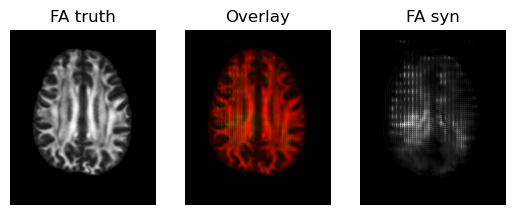

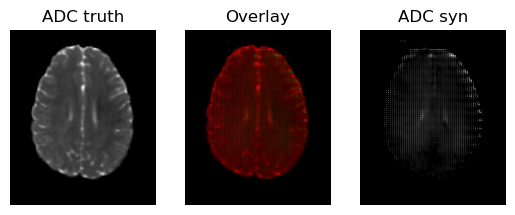

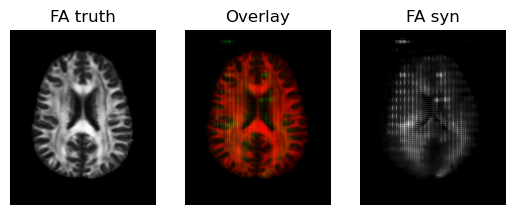

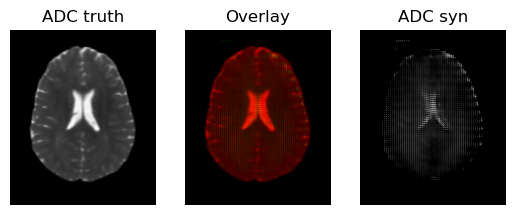

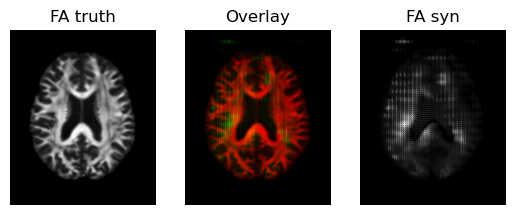

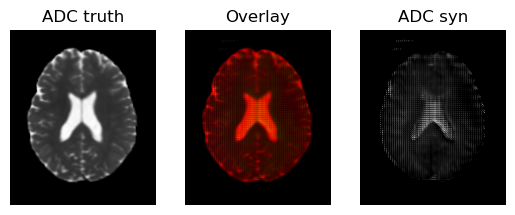

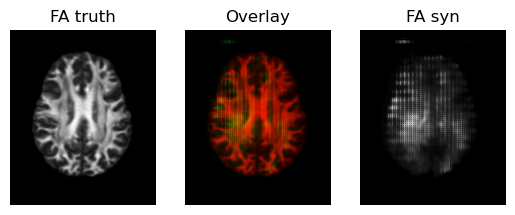

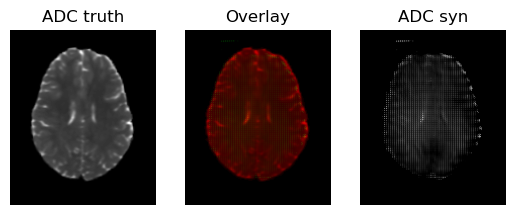

In [20]:
# outs = model(inputs)
# outputs = Gouts.cpu()
# targets = targets.cpu()
# for i, (inputs, targets) in enumerate(val_dataloader):
#             true_labels = torch.ones(inputs.shape[0], 2)
#             false_labels = torch.zeros(inputs.shape[0], 2)
#             if use_gpu:
#                 inputs = inputs.to(device)
#                 targets = targets.to(device)
#                 true_labels = true_labels.to(device)
#                 false_labels = false_labels.to(device)
#             inputs = inputs.float()
#             targets = targets.float()
            
#             Gouts = G(inputs)
plot_samples = [140, 150, 160, 165]
G.eval()
for i in range(len(plot_samples)):
    (inputs, targets) = train_dataset.__getitem__(plot_samples[i])
    inputs = inputs.to(device)
    inputs = inputs.float()
    targets = targets.float()
    inputs = inputs[None]
    targets = targets[None]
    outputs = G(inputs)
    inputs = inputs.cpu()
    outputs = outputs.cpu()
    tg0 = targets[0, 0] / torch.max(targets[0, 0])
    tg1 = targets[0, 1] / torch.max(targets[0, 1])
    regtools.overlay_slices(tg0.numpy(), outputs[0, 0].detach().numpy(), None, 2,
                                    "FA truth", "FA syn")
    regtools.overlay_slices(tg1.numpy(), outputs[0, 1].detach().numpy(), None, 2,
                                    "ADC truth", "ADC syn")
    # print(torch.min(targets[i, 0]), torch.min(outputs[i, 0]))
    # print(torch.min(targets[i, 1]), torch.min(outputs[i, 1]))


GROUND TRUTH CHARACTERISTICS

In [ ]:
with torch.no_grad():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    mins = torch.zeros(len(trainmask), 2)
    maxes = torch.zeros(len(trainmask), 2)
    idx = 0
    for i, (inputs, targets) in enumerate(train_dataloader):
        # inputs = inputs.to(device)
        targets = targets.to(device)
        mins[idx:idx+inputs.shape[0], 0] = torch.tensor([[torch.min(targets[j, 0]) for j in range(inputs.shape[0])]])
        mins[idx:idx+inputs.shape[0], 1] = torch.tensor([[torch.min(targets[j, 1]) for j in range(inputs.shape[0])]])
        maxes[idx:idx+inputs.shape[0], 0] = torch.tensor([[torch.max(targets[j, 0]) for j in range(inputs.shape[0])]])
        maxes[idx:idx+inputs.shape[0], 1] = torch.tensor([[torch.max(targets[j, 1]) for j in range(inputs.shape[0])]])
        # print(mins, maxes)
        idx += inputs.shape[0]
    

In [ ]:
plt.figure()
plt.plot(mins[:, 0])
plt.plot(maxes[:, 0])
plt.legend(['min', 'max'])
plt.xlabel('Sample')
plt.ylabel('Intensity')
plt.title('FA')
plt.figure()
plt.plot(mins[:, 1])
plt.plot(maxes[:, 1])
plt.legend(['min', 'max'])
plt.title('ADC')
plt.xlabel('Sample')
plt.ylabel('Intensity')

In [11]:
print(torch.cuda.memory_allocated(0), torch.cuda.memory_allocated(1))

9999754240 9590642176


In [12]:
print(torch.cuda.device_count())

2


In [10]:
prediction = nn.functional.softmax(outputs[0], dim=0)
# Scale down the target when calculating loss
pool = nn.AvgPool3d(4)
target = pool(targets[0])
TP1 = (prediction[0]*target).sum(1).sum(1).sum(1)
TP2 = (prediction[0]*target).sum()
print(TP1, TP2)

tensor([296.8278], device='cuda:0') tensor(296.8278, device='cuda:0')


Text(0, 0.5, 'MAE')

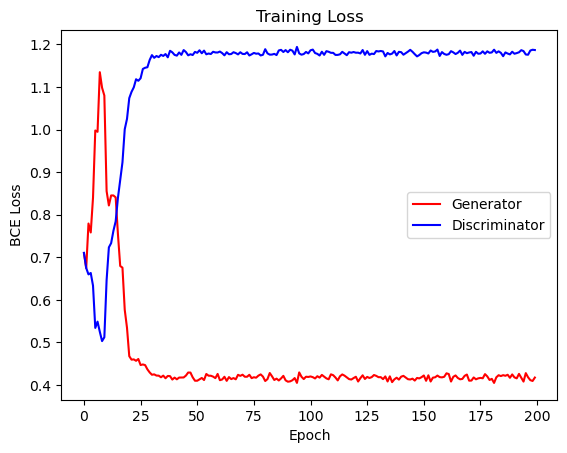

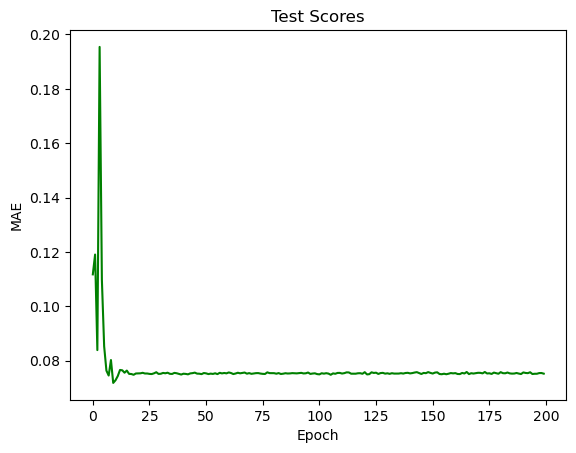

In [15]:
# plt.plot(trainloss)
# plt.plot(valloss)
# plt.plot(testscores)
plt.figure()
plt.title('Training Loss')
plt.plot(trainlossG, 'red')
plt.plot(trainlossD, 'blue')
plt.legend(["Generator", "Discriminator"])
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')

plt.figure()
plt.title('Test Scores')
plt.plot(testscores, 'green')
plt.xlabel('Epoch')
plt.ylabel('MAE')
# ax2.legend(["test"])

# print(trainloss[0:5], valloss[0:5], testscores[0:5])

In [16]:
targets= torch.zeros(1, 1, 188, 227, 288)
targets = torch.cat([targets, 1-targets], dim=1)
print(targets.shape)

torch.Size([1, 2, 188, 227, 288])


In [8]:
torch.cuda.empty_cache()

In [ ]:
np.save("ImageSizes.npy", imgshapes)

VISUALIZATION

In [40]:
## GET STATISTICS ON WHERE THE TUMORS LIE WITHIN THE SEGMENTATION MASKS

torch.manual_seed(43) # need this when we retrieve
stats = torch.zeros(len(train_dataloader)*train_batch_size, 9) # datapts x 6(cl,cw,ch,ml,mw,mh)
for i, (inputs, targets, labels) in enumerate(train_dataloader):
    for j in range(targets.size()[0]):
        tg = targets[j]
        # print(tg.size())

        # Get indexes of the voxels with 1 (tumor label)
        tumoridx = torch.nonzero(tg)[:, -3:].float() # result will be N(nonz px)x3(l,w,h)
        # print(tumoridx.size())

        # Get the centroid of the tumor and upper and lower bounds in each dimension
        tcenter = torch.mean(tumoridx, dim=0) # result is 1x3(l,w,h)
        tmins = torch.min(tumoridx, dim=0)[0]
        tmaxes = torch.max(tumoridx, dim=0)[0]

        stats[i*train_batch_size+j] = torch.cat((tmins, tcenter, tmaxes))

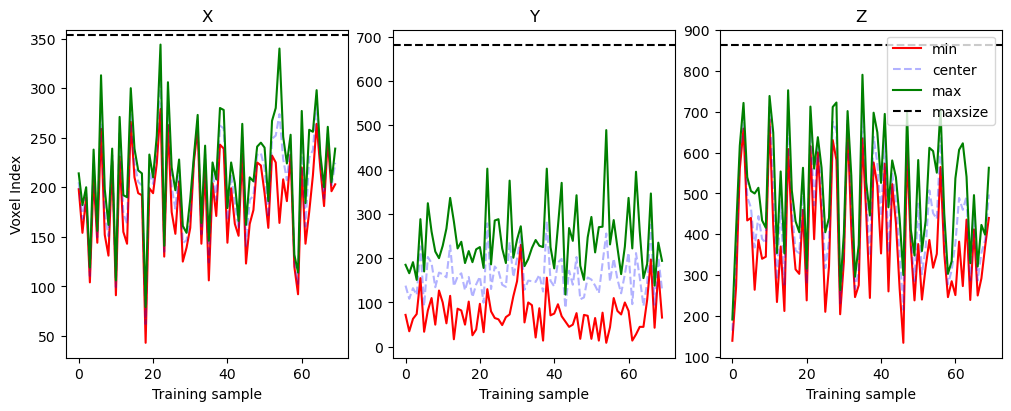

In [53]:
## PLOT TUMOR LOCATION STATS 

fig, axs = plt.subplots(1, 3, layout="constrained", figsize=(10, 4))
titles = ["X", "Y", "Z"]
maxsizes = [354, 682, 865]

axs[0].set_ylabel("Voxel Index")
for k in range(3):
    axs[k].plot(stats[:, k], color='red', linestyle='-', label="min")
    axs[k].plot(stats[:, k+3], color='blue', linestyle='--', alpha=0.3, label='center')
    axs[k].plot(stats[:, k+6], color='green', linestyle='-', label='max')
    axs[k].set_title(titles[k])
    axs[k].set_xlabel("Training sample")
    axs[k].axhline(y=maxsizes[k], color='black', linestyle='--', label='maxsize')
plt.legend()

Analyzing images for patient 069
Image size: (108, 85, 44)
1.0 1.0
Analyzing images for patient 070
Image size: (108, 85, 44)
1.0 1.0


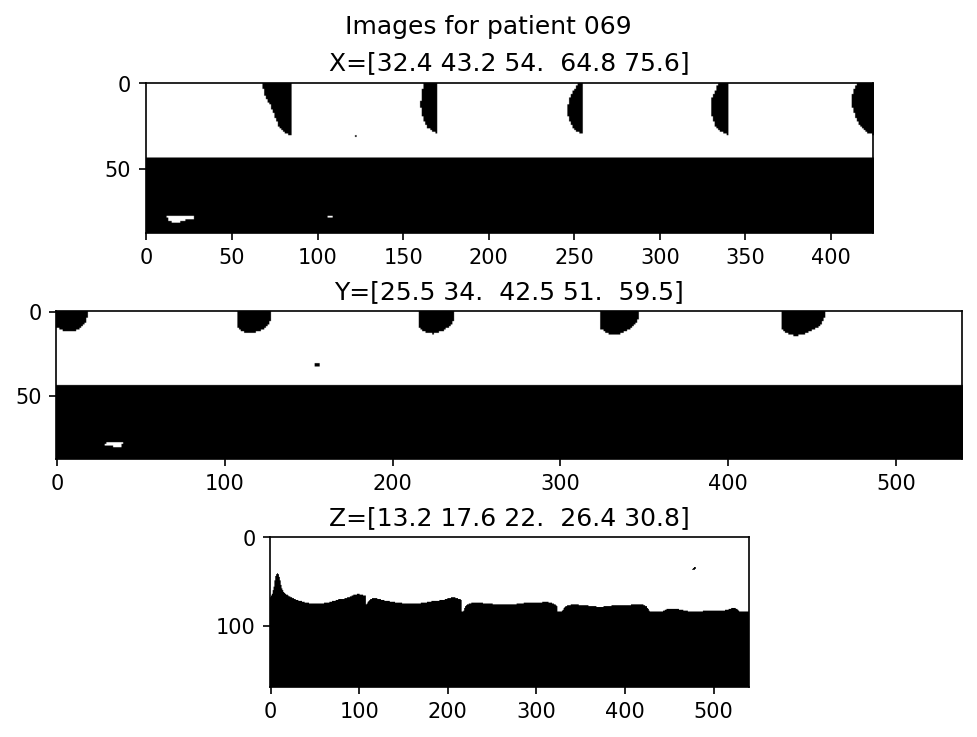

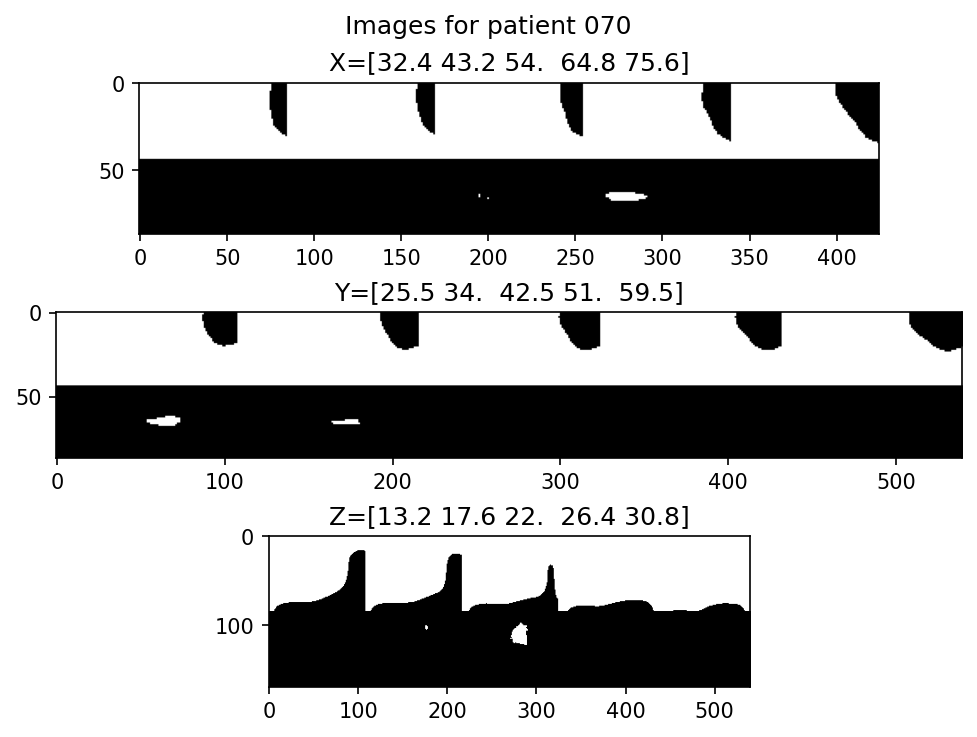

In [22]:
## PLOT SELECTED TRAINING SAMPLES ALONG WITH THEIR SEGMENTATION MASK

dir = os.path.join("Train-20230419T152017Z-001", "Train")
data_dir = os.path.join(dir, "DATA")
mask_dir = os.path.join(dir, "MASK")
label_dir = dir

slices = np.array([i/10 for i in range(3, 8)]) # slices to plot for validation (given as percentage through the height)
showresults = ["069", "070"] # choose the directories to plot the results for
for f in os.listdir(data_dir):
    if f[-8:-5] in showresults:
        # Show current directory
        print(f"Analyzing images for patient {f[-8:-5]}")
        maskname = os.path.join(mask_dir, f"MASK{f[-9:]}")
#         img = sitk.ReadImage(os.path.join(data_dir, f))
        mask = sitk.ReadImage(maskname)# * 255
        idx = int(f[-8:-5])
        img = outputs[idx-69]
        img = torch.argmin(img, dim=0)
        img = img.float().cpu()
#         img = torch.tensor(sitk.GetArrayFromImage(img))
        mask = torch.tensor(sitk.GetArrayFromImage(mask))
        pool = nn.MaxPool3d(8)
#         img = pool(img[None, None, :].float())
        mask = pool(mask[None, None, :].float())
#         img = img[0, 0]
#         mask = mask[0, 0]
        img_idx = torch.nonzeros(img)
        
        img = sitk.GetImageFromArray(img.numpy())
        mask = sitk.GetImageFromArray(mask[0, 0].numpy())
        # scale = 3
        # sz = img.GetSize()
        # temp = sitk.Image(int(sz[0]/scale), int(sz[1]/scale), int(sz[2]/scale), sitk.sitkUInt8)
        # img = sitk.Resample(img, temp, transform=sitk.ScaleTransform(3, (1, 1, 1)))
        # mask = sitk.Resample(mask, temp, transform=sitk.ScaleTransform(3, (1, 1, 1)))
        # Confirm sizes are correct
        sz = img.GetSize()
        print(f"Image size: {sz}")

        # Generate tiles of multiple top-down slices to plot
        Xslices = [img[int(s*sz[0]), :, :] for s in slices] + [mask[int(s*sz[0]), :, :] for s in slices]
        Yslices = [img[:, int(s*sz[1]), :] for s in slices] + [mask[:, int(s*sz[1]), :] for s in slices]
        Zslices = [img[:, :, int(s*sz[2])] for s in slices] + [mask[:, :, int(s*sz[2])] for s in slices]
        print(np.max(sitk.GetArrayFromImage(img)), np.max(sitk.GetArrayFromImage(mask)))
        # print(type(mask), type(img))
        
        # Convert tiles to arrays for plotting
        Xarr = sitk.GetArrayFromImage(sitk.Tile(Xslices, [len(slices), 2]))
        Yarr = sitk.GetArrayFromImage(sitk.Tile(Yslices, [len(slices), 2]))
        Zarr = sitk.GetArrayFromImage(sitk.Tile(Zslices, [len(slices), 2]))
        # print(Xarr.shape, Yarr.shape, Zarr.shape)

        # Plot tiles
        fig, axs = plt.subplots(3, 1, constrained_layout=True)
        # plt.figure()
        axs[0].imshow(Xarr, cmap='gray')
        axs[0].set_title(f"X={sz[0]*slices}")
        axs[1].imshow(Yarr, cmap='gray')
        axs[1].set_title(f"Y={sz[1]*slices}")
        axs[2].imshow(Zarr, cmap='gray')
        axs[2].set_title(f"Z={sz[2]*slices}")
        fig.suptitle(f"Images for patient {f[-8:-5]}")
        fig.set_dpi(150)